In [1]:
DATA_DIR = "/run/media/maciej/Nowy/data/json/"
OUTPUT_FILE = "results.txt"

In [2]:
import json
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np


def run_on_files(func, ):
    file_idx = 0
    
    files = os.listdir(DATA_DIR)
    results = []
    for file in tqdm(files):
        if file.startswith("judgment"):
        
            file_path = os.path.join(DATA_DIR, file)
            
            with open(file_path, 'r') as f:
                data = json.load(f)
                results.append(func(data))
                
    return results
                



# 1. Szukanie kwot z roku 2011

>Wydostań wszystkie wartości pieniężne wyrażone w złotych pojawiające się tekstach orzeczeń określonego roku, znormalizuj je i...

In [3]:
def normalize(amount, pennies, factor):
#     filtered_value = [character for character in amount if character not in ". "]
    pattern = re.compile(r';|’|\.|\s+')
    filtered_value = re.sub(pattern, '', amount)
    joined_digits = "".join(filtered_value)
    
    full_money_value = int(joined_digits)
    
    factor_mappings = {
        'mld': 10**9,
        'mln': 10**6,
        'tys': 10**3,
    }
    factor = factor_mappings.get(factor, 1)
    
    if pennies is None:
        pennies = 0
    penny_value = float("0.{}".format(pennies))
    
    return (full_money_value + penny_value) * factor

In [4]:
NUMBER = """(?P<money>\d+((?P<separator>[;’\.\s])\d{3}((?P=separator)\d{3})*)?\s*)"""
PENNIES = "(\,\s*(?P<pennies>\d{2,}))?\s*"
FACTOR = "((?P<factor>tys|mld|mln)\.?\s*)?"

ENDINGS = [
    "pty", # złptych
    "oty", # złotych
    "[^a-zA-Z]", # zł. zł, zł 
    "o-\s+tych", # zło-\ntych
]
JOINED_ENDINGS = "|".join(ending for ending in ENDINGS)
CURRENCY = "zł(" + JOINED_ENDINGS + ")"

DETAILED_MONEY_REGEX = NUMBER + PENNIES + FACTOR + CURRENCY
print(DETAILED_MONEY_REGEX)


(?P<money>\d+((?P<separator>[;’\.\s])\d{3}((?P=separator)\d{3})*)?\s*)(\,\s*(?P<pennies>\d{2,}))?\s*((?P<factor>tys|mld|mln)\.?\s*)?zł(pty|oty|[^a-zA-Z]|o-\s+tych)


In [5]:
import re

def money_search(data):
    judgments = [x["textContent"] for x in data["items"] if x["judgmentDate"].startswith("2011")]
    
    for judgment in judgments:                        
        data = judgment
        with open(OUTPUT_FILE, 'a') as f:        
            for match in re.finditer(DETAILED_MONEY_REGEX, data, re.DOTALL):
                amount, pennies, factor = match.group('money', 'pennies', 'factor')
                
                normalized = normalize(amount, pennies, factor)
                f.write("{}\n".format(normalized))

    
_ = run_on_files(money_search)

100%|██████████| 3192/3192 [01:44<00:00, 30.57it/s]


In [15]:
def load_amounts():
    with open(OUTPUT_FILE, 'r') as f:
        data = [float(amount) for amount in f.readlines()]
    return data

In [18]:
amounts = load_amounts()
print("Found {} money amounts in the dataset.".format(len(amounts)))

Found 54551 money amounts in the dataset.


# (1&2) Histogramy
>1. Wydostań wszystkie wartości pieniężne wyrażone w złotych pojawiające się tekstach orzeczeń określonego roku, znormalizuj je i przedstaw ich rozkład w postaci histogramu.
>2. Jak w punkcie 1. ale zrób osobny wykres dla wartości do 1 mln zł. oraz powyżej 1 mln zł.

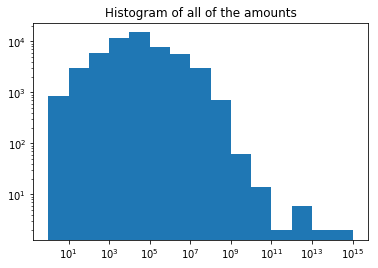

In [7]:
amounts = load_amounts()
plt.hist(amounts, bins=[10**x for x in range(0, 16)], log=True)
plt.title("Histogram of all of the amounts")
plt.xscale("log")
plt.show()

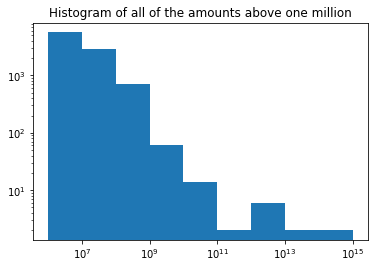

In [8]:
amounts = [amount for amount in load_amounts() if amount >= 10**6]
plt.hist(amounts, bins=[10**x for x in range(6, 16)], log=True)
plt.title("Histogram of all of the amounts above one million")
plt.xscale("log")
plt.show()

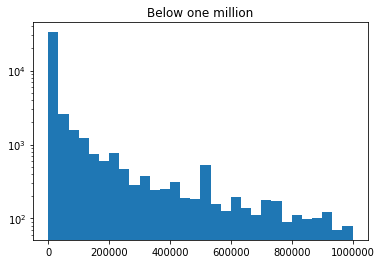

In [17]:
amounts = [amount for amount in load_amounts() if amount < 10**6]
plt.hist(amounts, bins=30, log=True)
plt.title("Below one million")
plt.show()

# 3. Ustawa
> Określ liczbę orzeczeń odwołujących się w 2011 roku do artykułu 445 Ustawy z dnia 23 kwietnia 1964 r. - Kodeks cywilny.

In [10]:
act_regex = r"Ust(awa|\.) z dnia 23 kwietnia 1964"
code = ".*cywiln.*"
article = "(?P<article>art\.\s*445)"
regex = act_regex + ".*" + code + article
def references_func(data):
    judgmentReferences = [x["referencedRegulations"] for x in data["items"] if x["judgmentDate"].startswith("2011")]
    
    total = 0
    for references in judgmentReferences:
        referenced = False
        for reference in references:
            if re.search(regex, reference['text'], re.IGNORECASE):
                referenced = True
        if referenced:
            total += 1
    return total
            
print(sum(run_on_files(references_func)))

100%|██████████| 3192/3192 [01:48<00:00, 29.48it/s]

76


# 4. Szkoda
> Określ liczbę orzeczeń w określonym roku, które zawierają słowo szkoda w dowolnej formie fleksyjnej. Wynik ten nie może obejmować innych słów, które mają wspólny prefiks ze słowem szkoda, np. szkodzić, szkodzący, itp.


In [11]:
szkoda_regex = r"\b(szkod(a|y|zie|ę|ą|o|om|ach|ami)|szkód)\b"
def szkoda_func(data):
    judgments = [x["textContent"] for x in data["items"] if x["judgmentDate"].startswith("2011")]

    mentions = 0
    for judgment in judgments:
        if re.search(szkoda_regex, judgment):
            mentions += 1
    return mentions
mentions = run_on_files(szkoda_func)
print(sum(mentions))

100%|██████████| 3192/3192 [01:42<00:00, 31.07it/s]

1824


# 5. Zajęcia - szukanie liczby kwot z roku 2004

In [12]:
import re

def money_occurrence_2004(data):
    judgments = [x["textContent"] for x in data["items"] if x["judgmentDate"].startswith("2004")]
    
    results = 0
    for judgment in judgments:                        
        data = judgment
        with open(OUTPUT_FILE, 'a') as f:        
            for match in re.finditer(DETAILED_MONEY_REGEX, data, re.DOTALL):
                amount, pennies, factor = match.group('money', 'pennies', 'factor')
                
                normalized = normalize(amount, pennies, factor)
                results += 1
                
    return results

    
money_in_2004 = run_on_files(money_occurrence_2004)


100%|██████████| 3192/3192 [01:40<00:00, 31.82it/s]


In [13]:
print(sum(money_in_2004))

2149
